### Below used for debugging indivudal circuit runs


In [38]:
from qiskit.circuit.library import QuantumVolume, EfficientSU2, TwoLocal, QFT
from qiskit import QuantumCircuit
from qiskit.circuit.library.standard_gates import iSwapGate, CXGate
from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import FakeQuitoV2
from qiskit.transpiler.coupling import CouplingMap
from qiskit.extensions import UnitaryGate
from weylchamber import canonical_gate

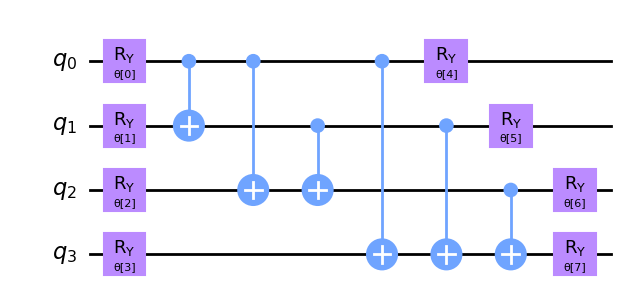

In [39]:
# 2Q Gate Costs:
# CX: {CX:1, sqiswap:2}
qc = TwoLocal(
    num_qubits=4,
    rotation_blocks="ry",
    entanglement_blocks=CXGate(),
    entanglement="full",
    reps=1,
)

# # CPHASE(pi/2): {CX:2, sqiswap:2}
# qc = TwoLocal(num_qubits=4,  rotation_blocks='ry', entanglement_blocks = CXGate().power(1/2), entanglement='full', reps=2)

# # iswap: {CX:2, sqiswap:2}
# qc = TwoLocal(num_qubits=4, rotation_blocks='ry', entanglement_blocks = iSwapGate(), entanglement='full', reps=2)

# # ECP: {CX:3, sqiswap:2}
# ecp = UnitaryGate(canonical_gate(0.5, 0.25, 0.25).full())
# qc = TwoLocal(
#     num_qubits=4,
#     rotation_blocks="ry",
#     entanglement_blocks=ecp,
#     entanglement="full",
#     reps=1,
# )

# SqiSwap: {CX:2, sqiswap:1}
# qc = TwoLocal(num_qubits=4, rotation_blocks='ry', entanglement_blocks= iSwapGate().power(1/2), entanglement='full', reps=2)

# qc = QFT(4)

# qc = QuantumCircuit(3)
# qc.ccx(0,1,2)
# qc.cx(0,1)
# qc.cx(0,2)

qc.decompose().draw("mpl", fold=-1)

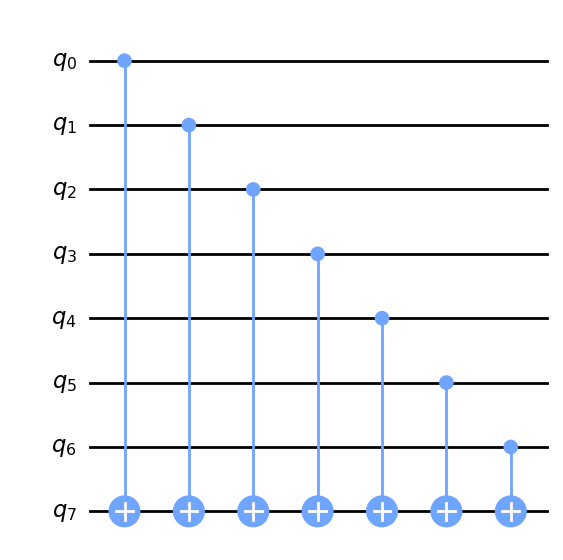

In [40]:
qc = QuantumCircuit(8)
qc.cx(0, 7)
qc.cx(1, 7)
qc.cx(2, 7)
qc.cx(3, 7)
qc.cx(4, 7)
qc.cx(5, 7)
qc.cx(6, 7)
qc.decompose().draw("mpl", fold=-1)

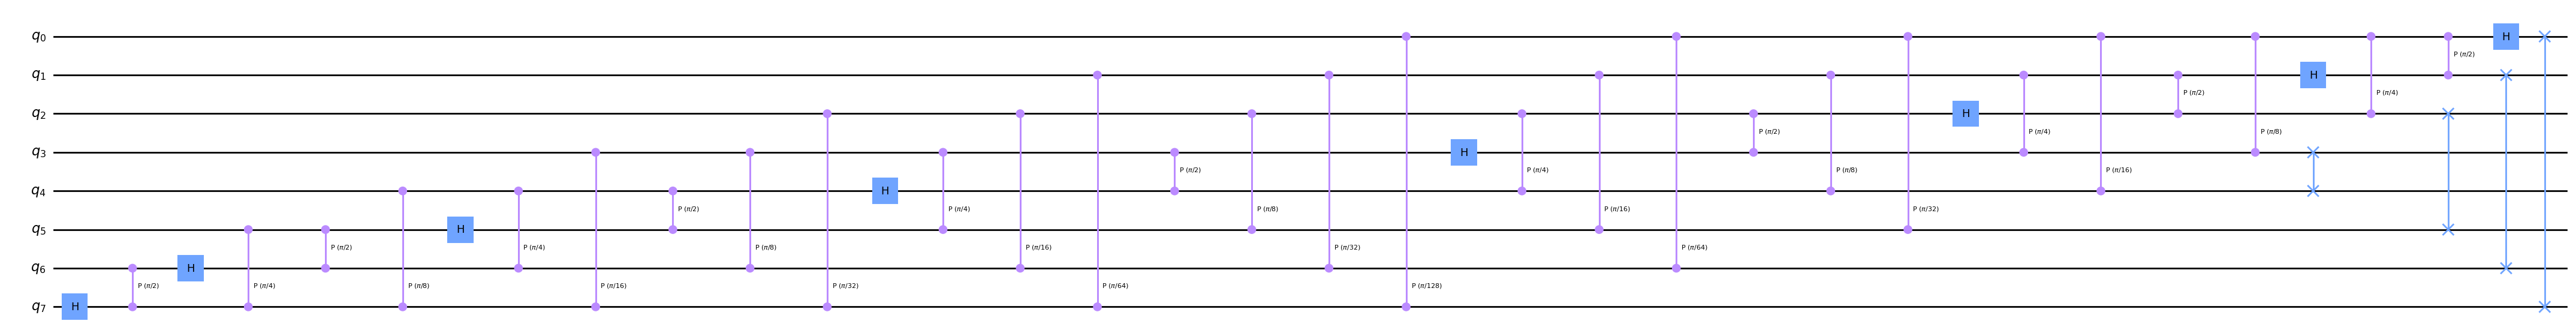

In [41]:
# import qiskit's qft
from qiskit.circuit.library import QFT

qc = QFT(8)
qc.decompose().draw("mpl", fold=-1)

In [49]:
coupling_map = FakeQuitoV2().target.build_coupling_map()
coupling_map = CouplingMap.from_line(8)
# coupling_map = CouplingMap.from_grid(4,4)
# coupling_map.draw()

0.25925925925925924
53


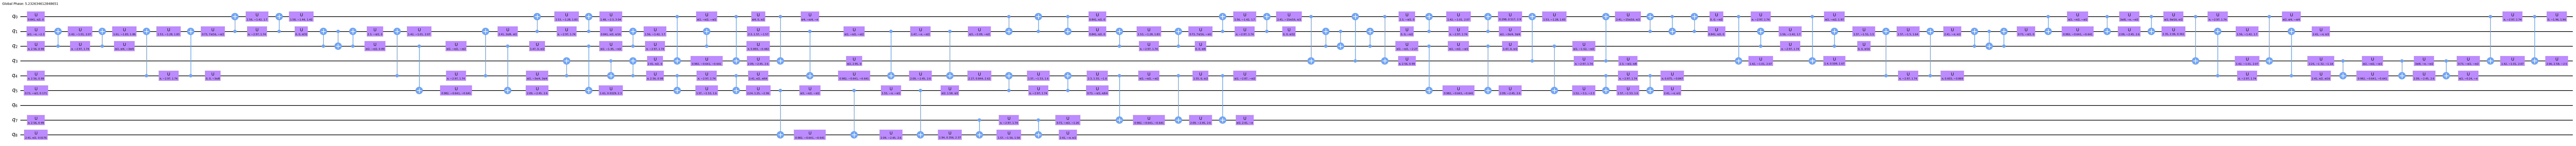

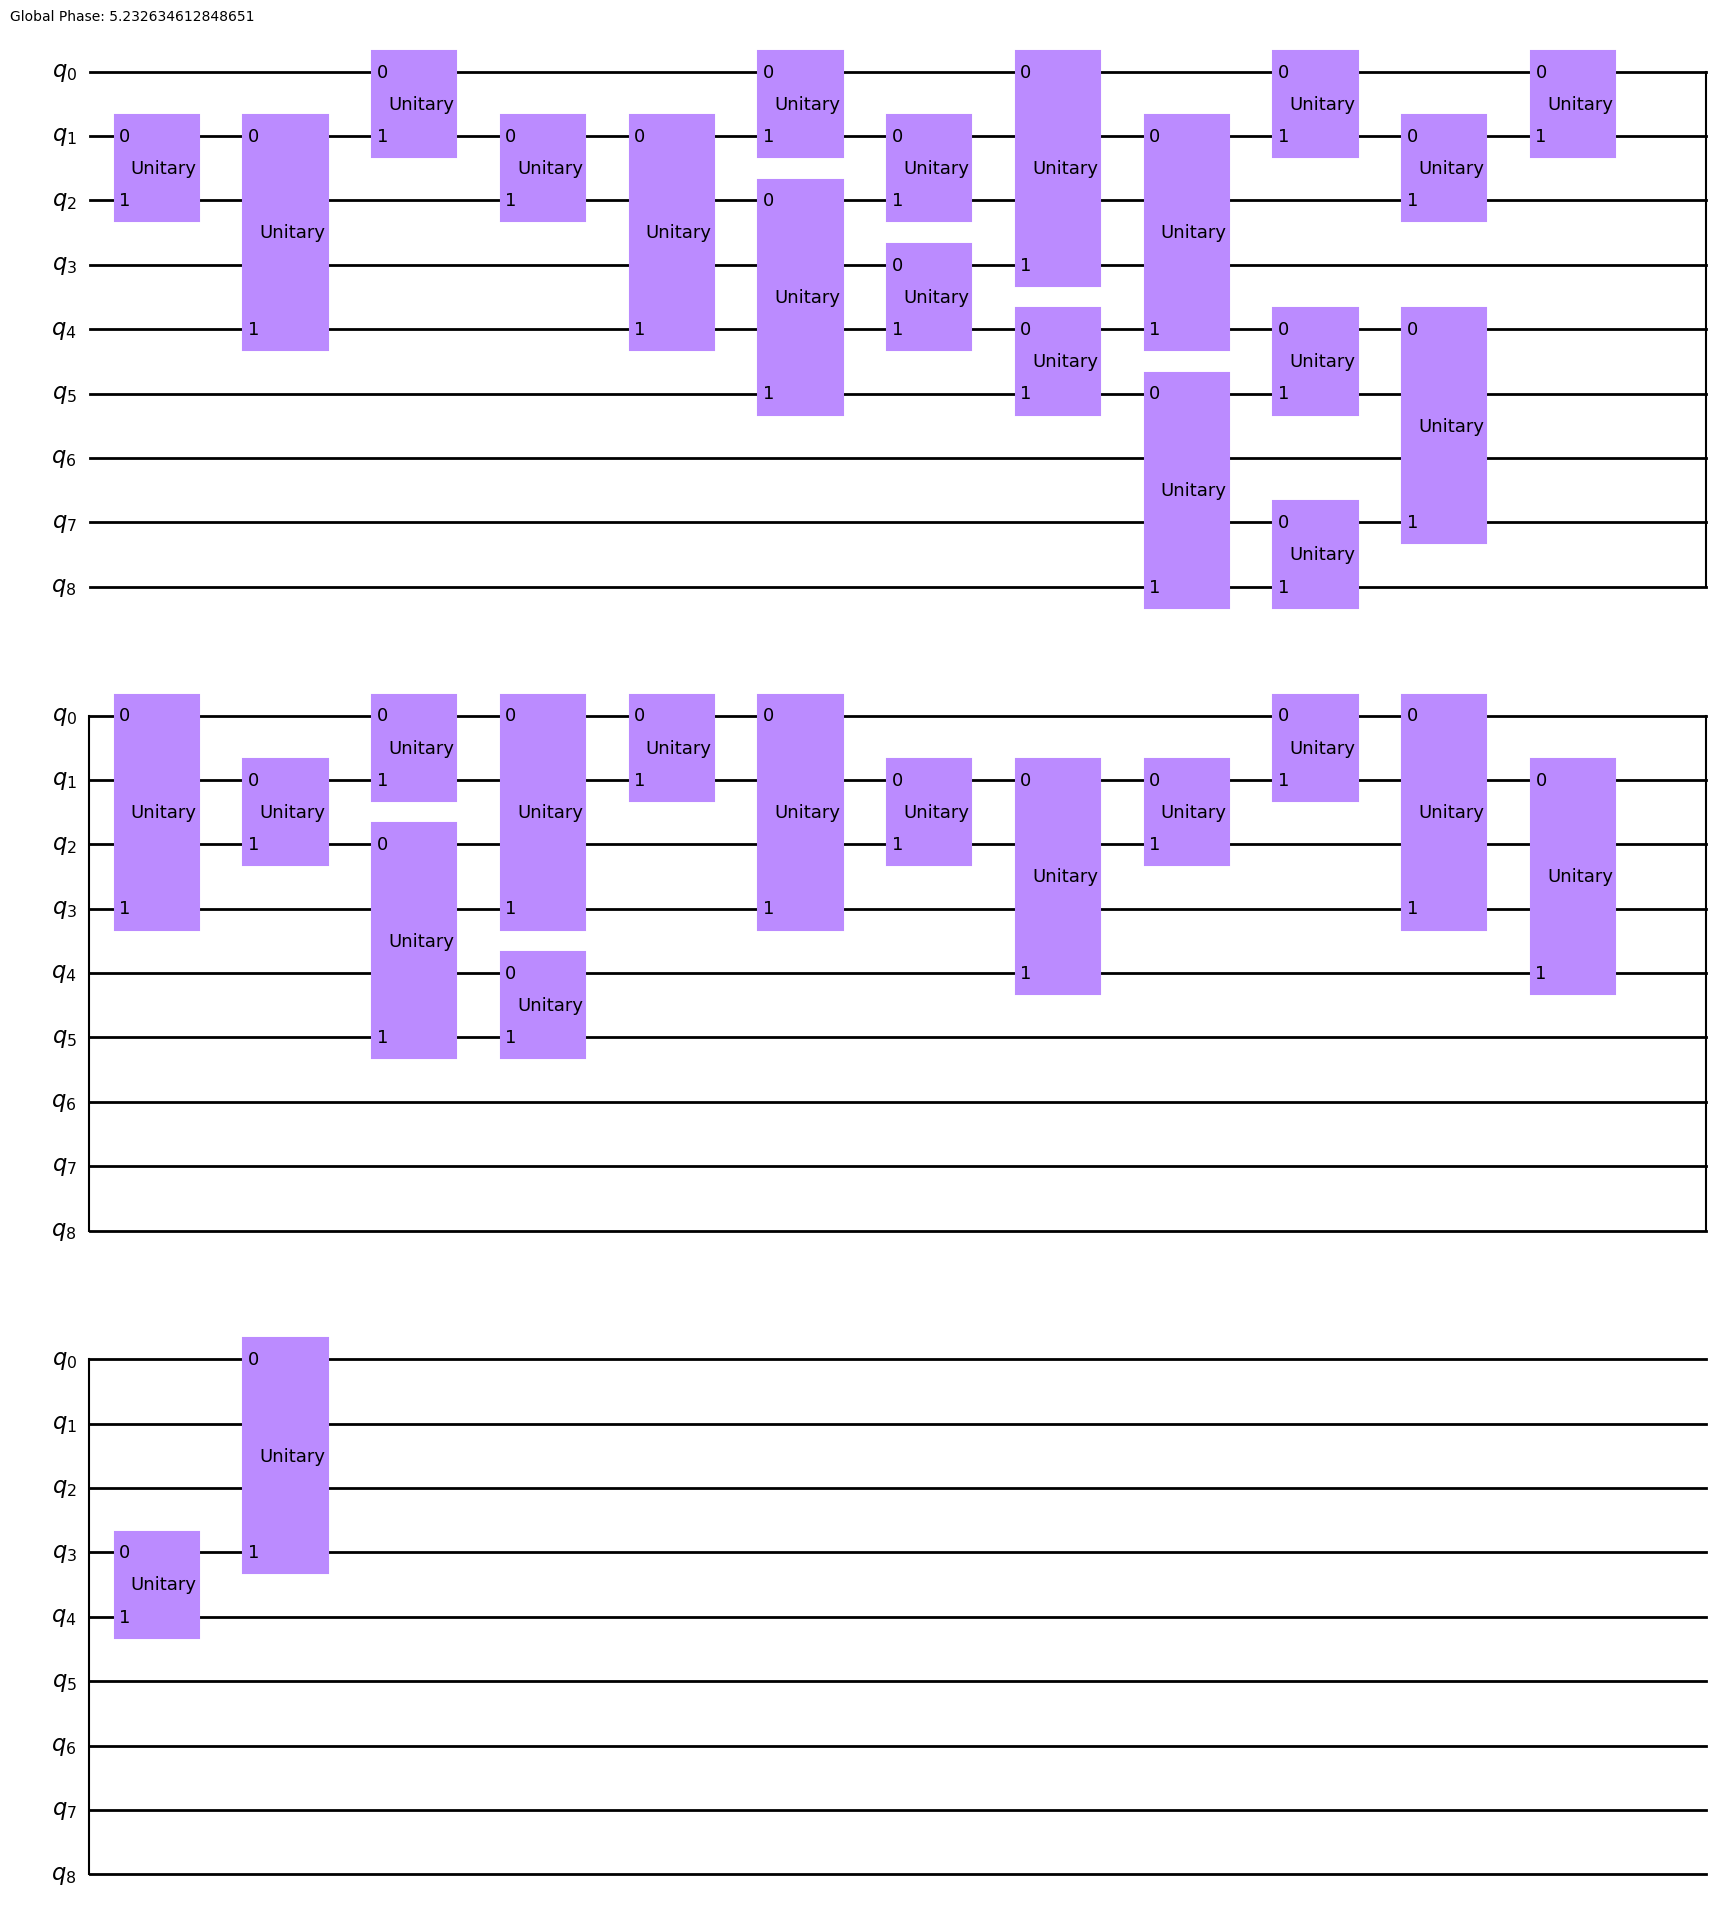

In [43]:
from virtual_swap.pass_managers import SabreVS, SabreQiskit
from transpile_benchy.metrics import DepthMetric

for _ in range(1):
    runner = SabreVS(coupling_map, cx_basis=True)
    transp = runner.run(qc)
    # mid0 = runner.pm.property_set["mid0"]
    mid = runner.pm.property_set["circuit_progress"]
    # print(DepthMetric.calculate(transp))
    print(runner.pm.property_set["accepted_subs"])
    print(runner.pm.property_set["monodromy_depth"])
display(mid.draw(output="mpl", fold=-1))  # , filename="qft_vs.svg")
display(transp.draw(output="mpl"))

In [44]:
# runner.pm.property_set["layout"]

57


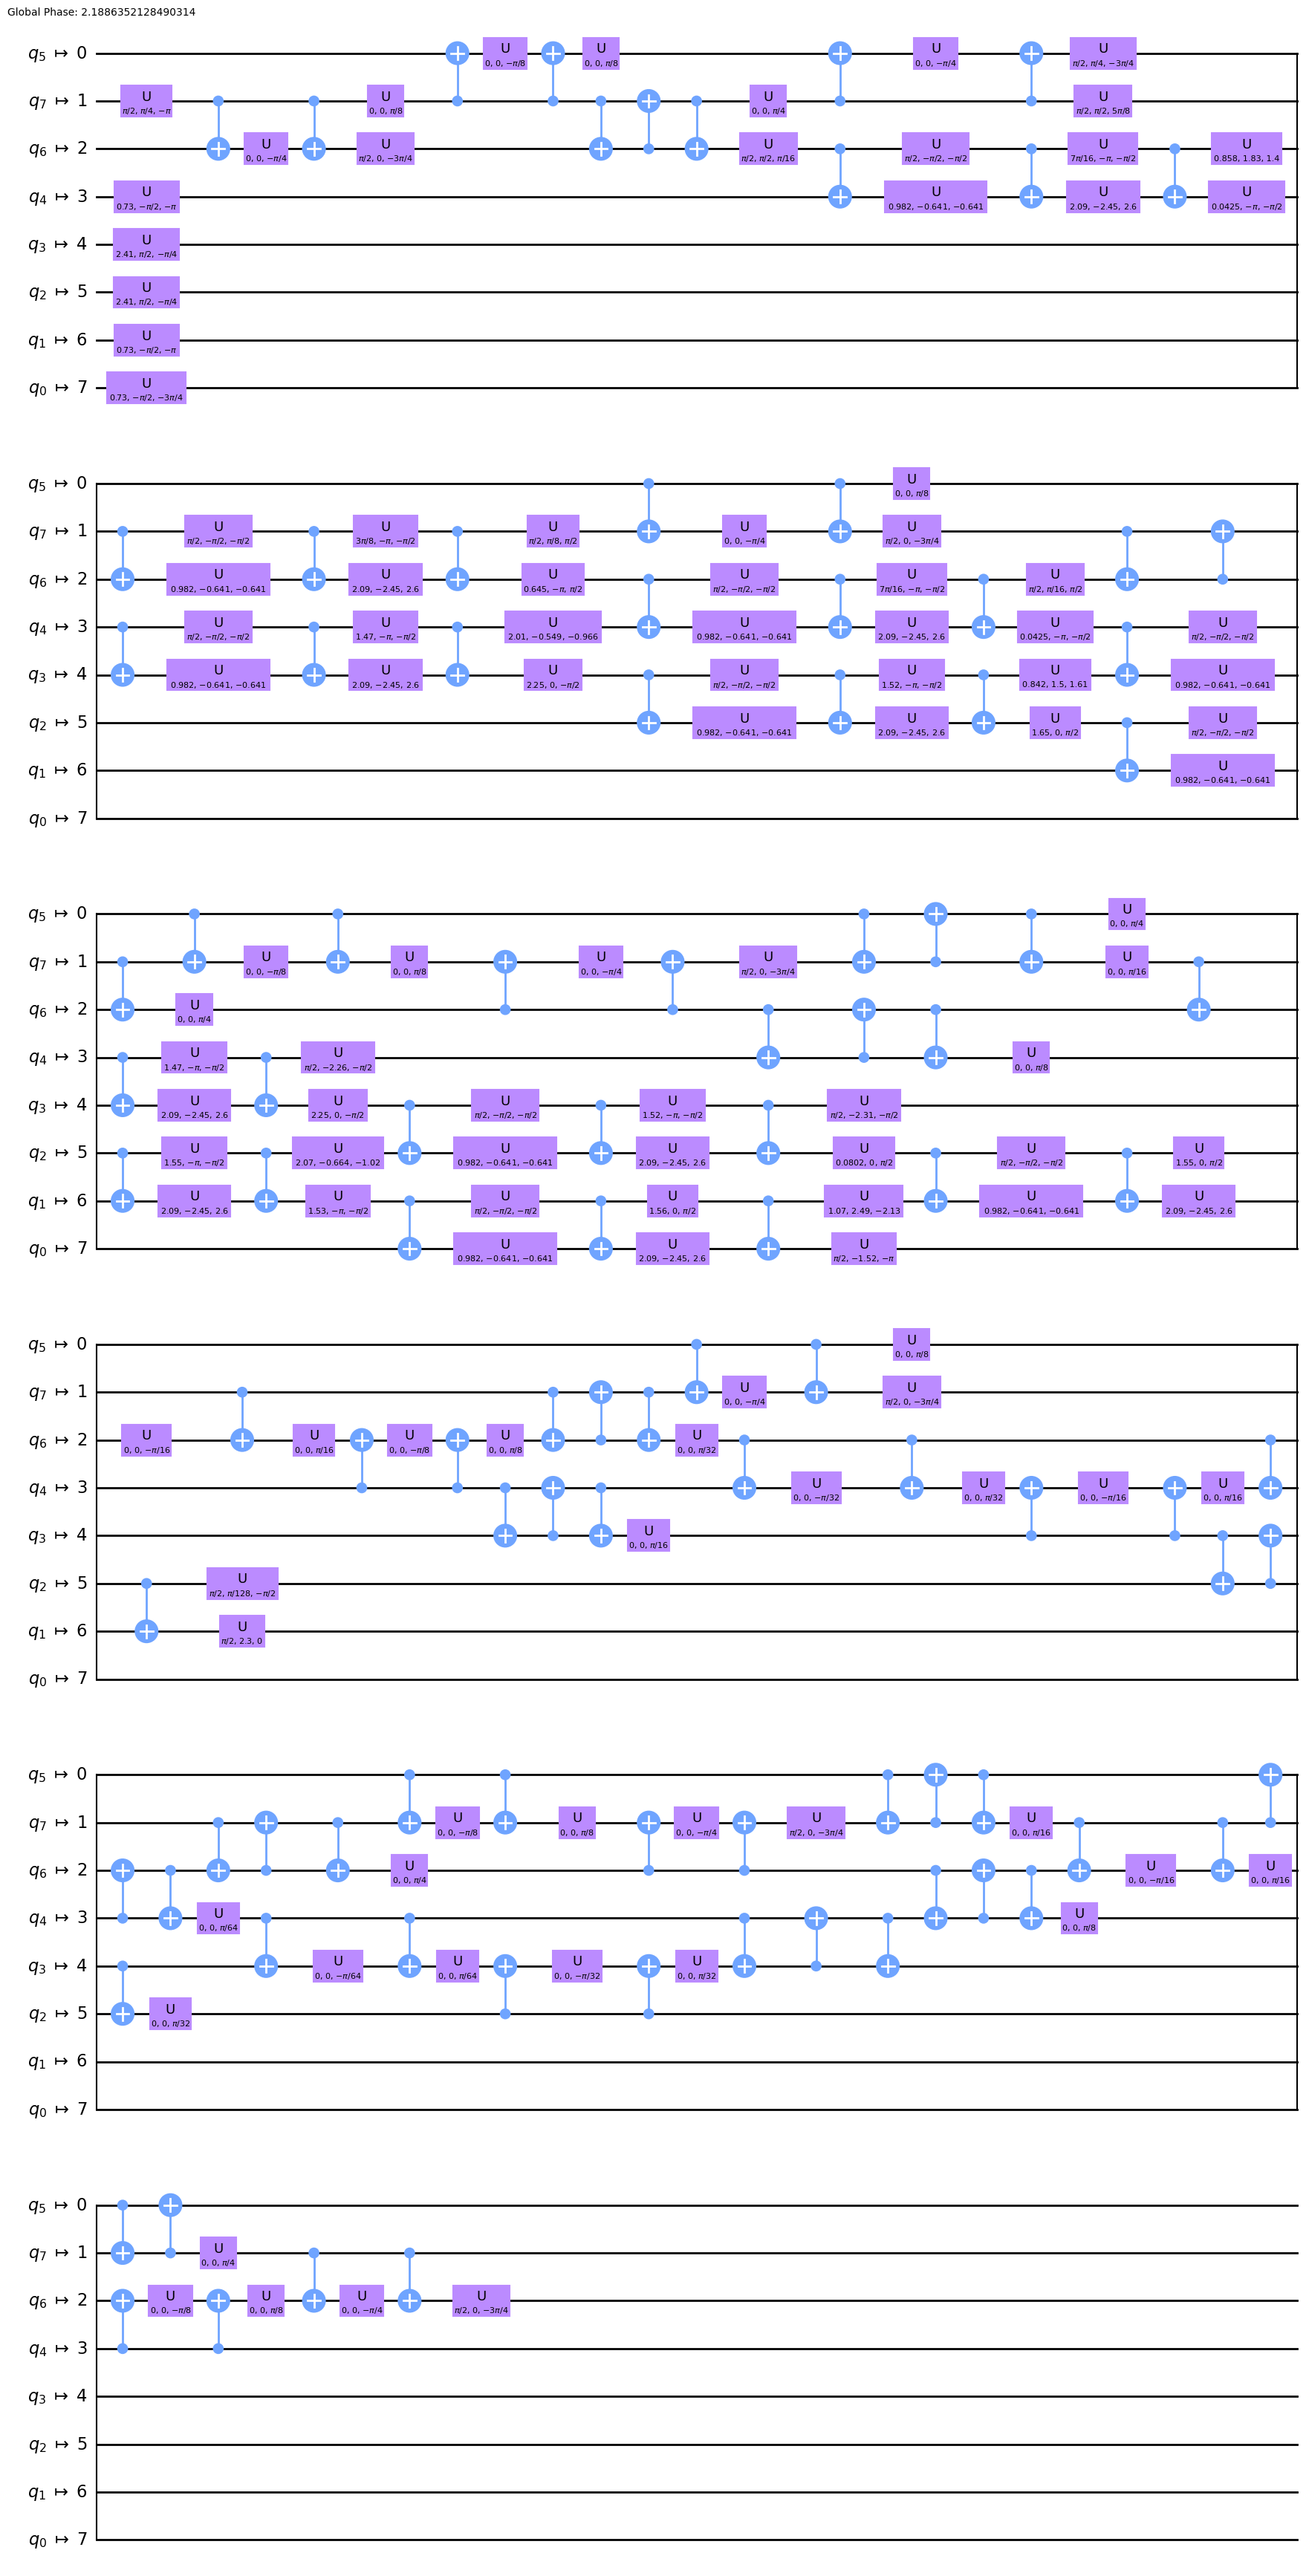

In [50]:
# set original qc to use
from qiskit import transpile
from virtual_swap.pass_managers import QiskitLevel3

# qc2 = transpile(qc, initial_layout=runner.pm.property_set["layout"], coupling_map=coupling_map)
# qc2 = transpile(qc, coupling_map=coupling_map, optimization_level=3)}

for _ in range(1):
    pm2 = QiskitLevel3(coupling_map, cx_basis=True)
    qc2 = pm2.run(qc)
    mid = pm2.pm.property_set["circuit_progress"]
    print(pm2.pm.property_set["monodromy_depth"])
# display(mid.draw(output="mpl", fold=-1))  # , filename="qft_qiskit.svg")
display(qc2.draw(output="mpl"))

In [46]:
# from qiskit.quantum_info import Operator
# Operator(mid).equiv(qc2)